# **Team Members:**
1. David Kaplansky
2. Dana Yim
3. Tsagaandari Battugs
4. Zi Jun Jiang
5. Ruiyang Cao




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# add model imports

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Data Processing and Visualization**

> We collected data for our final project, "Predicting the Wait Time of Starbucks at GSU," over a period of four weeks (from October 4th to October 31st) at 15-minute intervals during business hours. This dataset captures patterns in customer wait times across different times of day and days of the week, providing a foundation for our analysis and modeling.

The following steps were taken to process the data and generate preliminary visualizations:
1. **Data Processing**: Combined date and time columns to create a unified DateTime index. Extracted day of the week and time of day features for further analysis.
2. **Visualization**: Calculated and plotted the average wait times for each 15-minute interval across different days of the week. These visualizations highlight peak and low wait times, offering insights into customer flow patterns.



In [ ]:
data = pd.read_csv('drive/MyDrive/CS506_Final_Project/data/train.csv')

print(data.head())
print(data.shape)
print(data.dtypes)

      Day       Date        Time People in Line Wait Time (mins)
0  Friday  10/4/2024  7:00:00 AM           0.00                3
1  Friday  10/4/2024  7:15:00 AM           0.00                3
2  Friday  10/4/2024  7:30:00 AM           0.00                3
3  Friday  10/4/2024  7:45:00 AM           5.00               11
4  Friday  10/4/2024  8:00:00 AM           3.00                9
(1292, 5)
Day                 object
Date                object
Time                object
People in Line      object
Wait Time (mins)    object
dtype: object


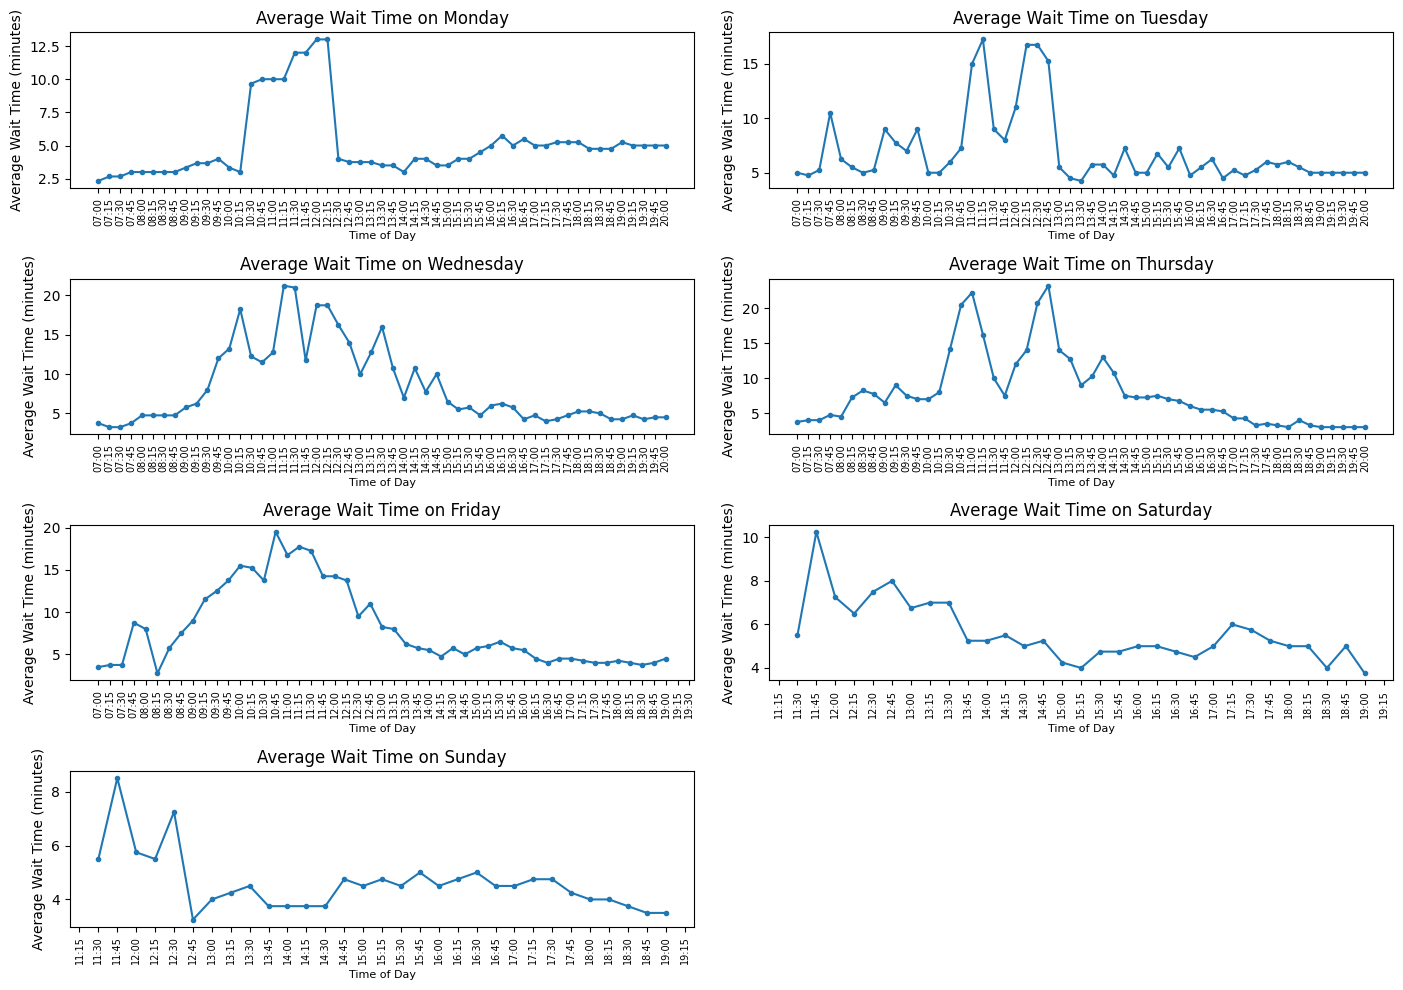

In [ ]:
# Convert Date and Time columns to string explicitly and parse to datetime
data['Date'] = data['Date'].astype(str)
data['Time'] = data['Time'].astype(str)
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')  # Coerce invalid entries to NaT
data.dropna(subset=['DateTime'], inplace=True)  # Drop rows where DateTime conversion failed

# Extract day of the week and set DateTime as the index
data['DayOfWeek'] = data['DateTime'].dt.day_name()
data.set_index('DateTime', inplace=True)

# Convert 'Wait Time (mins)' to numeric, handling non-numeric entries
data['Wait Time (mins)'] = pd.to_numeric(data['Wait Time (mins)'], errors='coerce')

# Group data by day of the week and 15-minute intervals, then calculate the average wait time
data['TimeOfDay'] = data.index.time  # Extract only the time component
average_wait = data.groupby(['DayOfWeek', 'TimeOfDay'])['Wait Time (mins)'].mean().unstack(level=0)

# Convert the index (time) to string format for plotting
time_labels = [time.strftime('%H:%M') for time in average_wait.index]

# Order days from Monday to Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting
plt.figure(figsize=(14, 10))

for i, day in enumerate(day_order):
    plt.subplot(4, 2, i + 1)
    plt.plot(time_labels, average_wait[day], marker='o', linestyle='-', markersize=3)  # Smaller dots
    plt.title(f'Average Wait Time on {day}')
    plt.xlabel('Time of Day', fontsize=8)  # Smaller x-axis label font size
    plt.ylabel('Average Wait Time (minutes)')
    plt.xticks(rotation=90, fontsize=7)  # Smaller x-axis tick font size

plt.tight_layout()
plt.show()


# **2. Data Modeling**


# Data Loading and Initial Processing

In this section, we load the dataset and perform initial data processing steps. Specifically, we:
1. Combine the `Date` and `Time` columns to create a `DateTime` column.
2. Extract relevant features such as `DayOfWeek` and `Hour` from `DateTime`.
3. Convert the target variable, `Wait Time (mins)`, to numeric format to ensure it can be used in model training.


In [ ]:
# Data Processing
# Combine Date and Time columns, convert to datetime, and drop any rows with invalid dates
data['Date'] = data['Date'].astype(str)
data['Time'] = data['Time'].astype(str)
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data.dropna(subset=['DateTime'], inplace=True)

# Extract day of the week and hour of the day as features
data['DayOfWeek'] = data['DateTime'].dt.day_name()
data['Hour'] = data['DateTime'].dt.hour

# Convert 'Wait Time (mins)' to numeric and drop rows with missing target values
data['Wait Time (mins)'] = pd.to_numeric(data['Wait Time (mins)'], errors='coerce')
data.dropna(subset=['Wait Time (mins)'], inplace=True)

# Feature Preparation and Preprocessing

In this section, we prepare the features and target variable for modeling. We:
1. Define the features (`DayOfWeek` and `Hour`) and target variable (`Wait Time (mins)`).
2. Set up preprocessing steps to:
   - One-hot encode the `DayOfWeek` feature (categorical).
   - Standardize the `Hour` feature (numerical).
3. These preprocessing steps are part of a pipeline, which simplifies model training and evaluation.


In [ ]:
# Prepare features (X) and target variable (y)
X = data[['DayOfWeek', 'Hour']]
y = data['Wait Time (mins)']

# Define preprocessing steps for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['DayOfWeek']),
        ('num', StandardScaler(), ['Hour'])
    ]
)

# Model Selection and Training

In this section, we define multiple regression models to predict wait time based on the day of the week and time of day. We will train the following models:
1. **Linear Regression**
2. **Decision Tree**
3. **Random Forest**
4. **K-Nearest Neighbors**

We fit each model and evaluate its performance using Mean Squared Error (MSE) for each day of the week.


In [ ]:
# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Train and evaluate each model
mse_results = {}
predicted_vs_actual = {}

for model_name, model in models.items():
    # Create a pipeline that includes preprocessing and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate Mean Squared Error for each day
    test_data = X_test.copy()
    test_data['True Wait Time'] = y_test
    test_data['Predicted Wait Time'] = y_pred
    test_data['Error'] = (test_data['True Wait Time'] - test_data['Predicted Wait Time']) ** 2

    mse_per_day = test_data.groupby('DayOfWeek')['Error'].mean()
    mse_results[model_name] = mse_per_day

    # Store actual and predicted wait times for each day for visualization
    predicted_vs_actual[model_name] = test_data


# Visualizing Mean Squared Error (MSE) Across Models

Here, we visualize the Mean Squared Error (MSE) for each model across different days of the week. This allows us to compare the models and identify the best-performing model in terms of accuracy for each day.


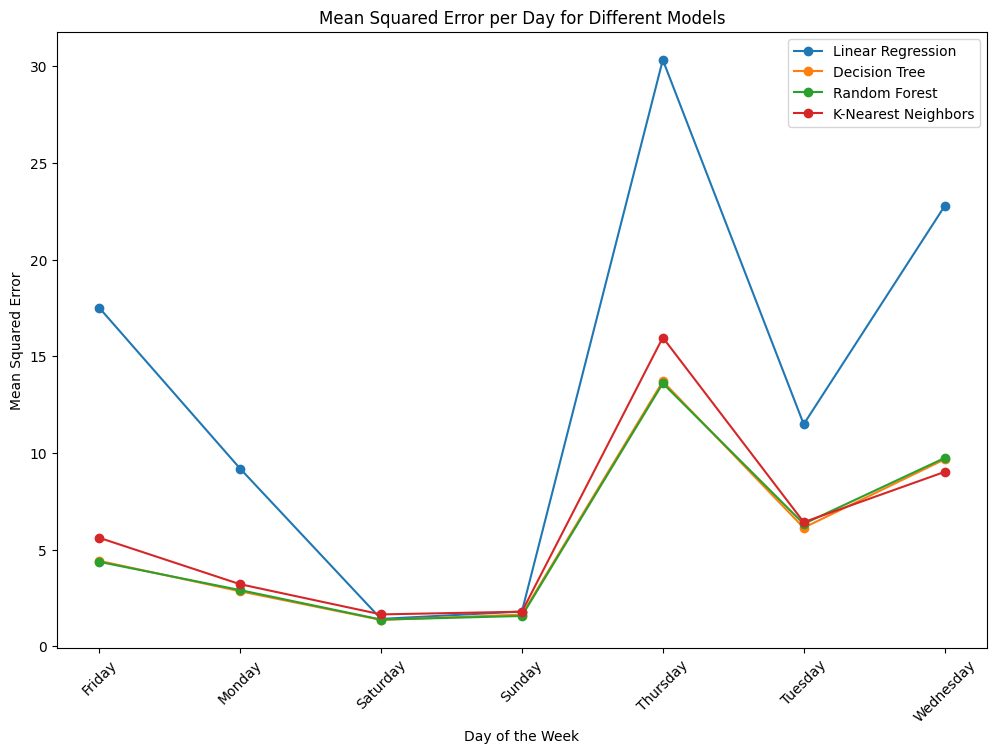

In [ ]:
# Step 1: Visualize MSE for each model across different days
plt.figure(figsize=(12, 8))
for model_name, mse_per_day in mse_results.items():
    plt.plot(mse_per_day.index, mse_per_day.values, marker='o', label=model_name)

plt.title('Mean Squared Error per Day for Different Models')
plt.xlabel('Day of the Week')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Selecting the Best Model Based on MSE

We identify the best model by selecting the one with the lowest average MSE across all days. This model will be used for further analysis, including visualizing the actual vs. predicted wait times.


In [ ]:
# Step 2: Select the best model based on overall MSE across days
for model_name, mse_per_day in mse_results.items():
    print(f"{model_name} MSE across days: {mse_per_day.mean()}")
best_model_name = min(mse_results, key=lambda x: mse_results[x].mean())
print(" ")
print(f"Best model based on MSE: {best_model_name}")

Linear Regression MSE across days: 13.505551004964298
Decision Tree MSE across days: 5.68729432375086
Random Forest MSE across days: 5.704930959777608
K-Nearest Neighbors MSE across days: 6.244453551261775
 
Best model based on MSE: Decision Tree


# Visualizing Predicted vs. Actual Wait Time for the Best Model

Using the best model identified, we plot the average predicted and actual wait times for each day of the week. By averaging the wait times for each hour, we create a smoother and more interpretable visualization that highlights how well the model predicts wait times across different days.


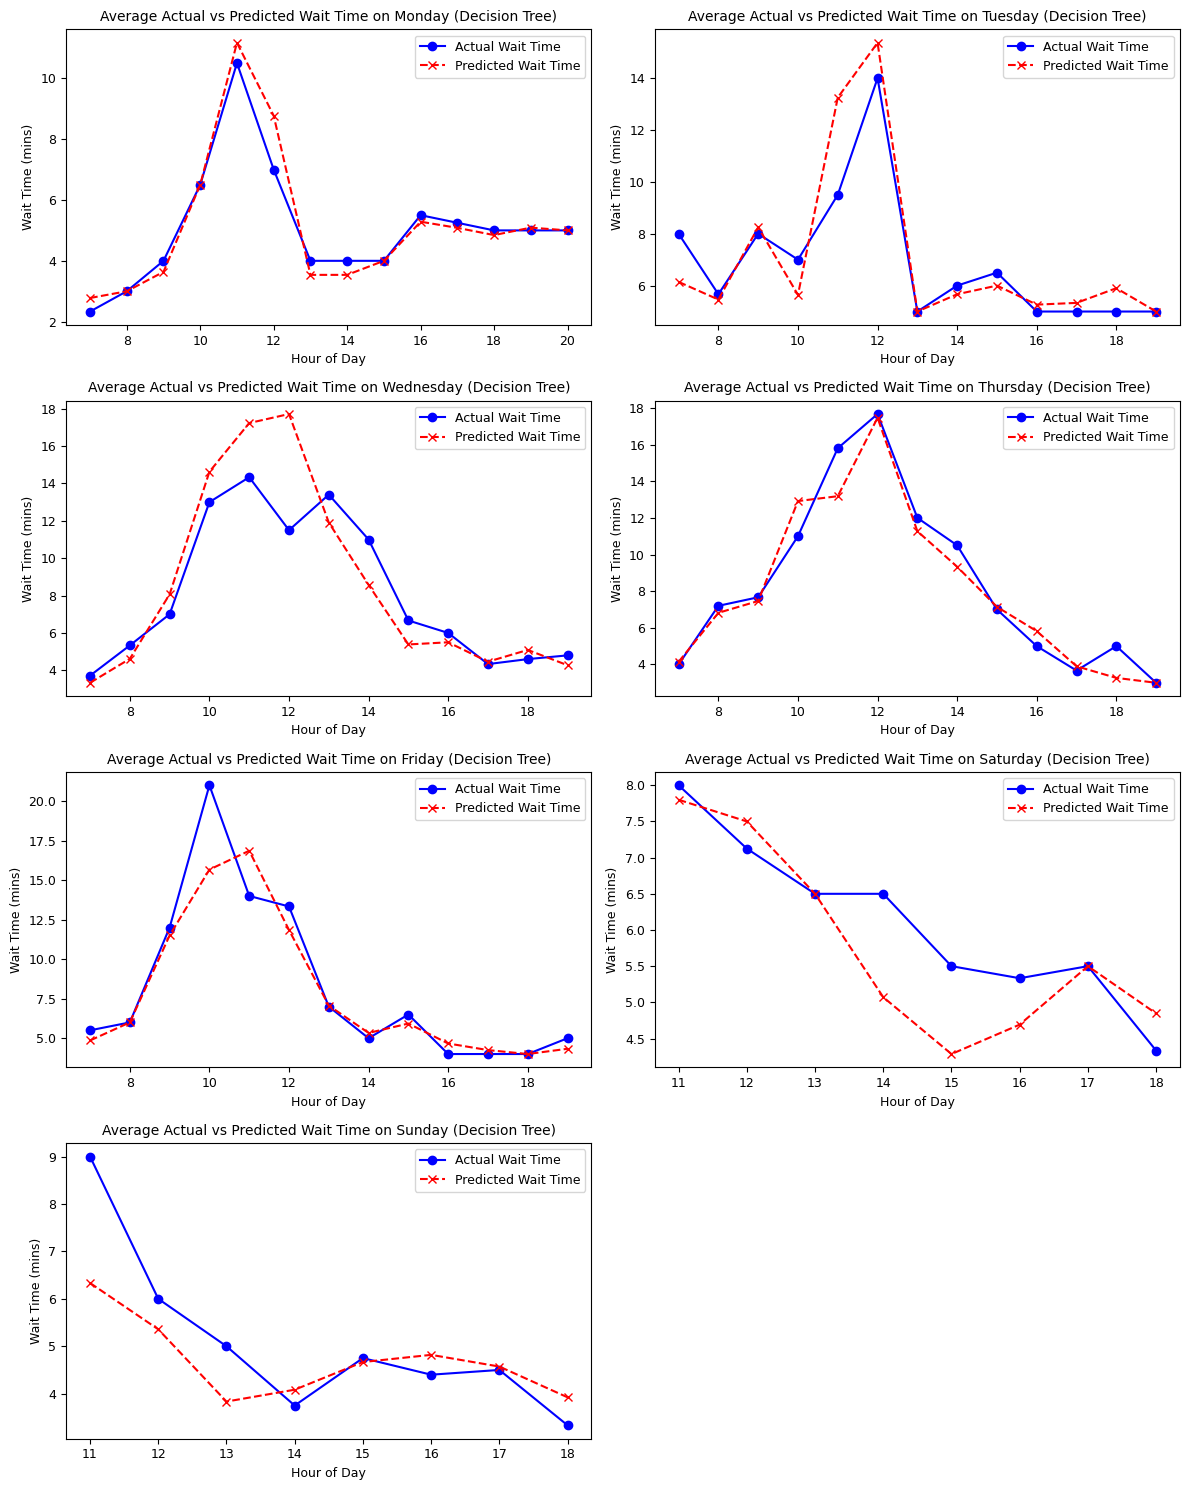

In [ ]:
# Order the days from Monday to Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Step 3: Visualize Predicted vs. Actual Wait Time for the Best Model (averaged per hour)
best_test_data = predicted_vs_actual[best_model_name]

plt.figure(figsize=(12, 15))  # Larger figure size for better readability
num_rows = (len(day_order) + 1) // 2  # Two plots per row

for i, day in enumerate(day_order):
    day_data = best_test_data[best_test_data['DayOfWeek'] == day]

    # Calculate the average actual and predicted wait times for each hour
    avg_day_data = day_data.groupby('Hour').agg({
        'True Wait Time': 'mean',
        'Predicted Wait Time': 'mean'
    }).reset_index()

    plt.subplot(num_rows, 2, i + 1)
    plt.plot(avg_day_data['Hour'], avg_day_data['True Wait Time'], label='Actual Wait Time', marker='o', linestyle='-', color='b')
    plt.plot(avg_day_data['Hour'], avg_day_data['Predicted Wait Time'], label='Predicted Wait Time', marker='x', linestyle='--', color='r')
    plt.title(f'Average Actual vs Predicted Wait Time on {day} ({best_model_name})', fontsize=10)
    plt.xlabel('Hour of Day', fontsize=9)
    plt.ylabel('Wait Time (mins)', fontsize=9)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.legend(fontsize=9)

plt.tight_layout()
plt.show()

# **3. Summary and Conclusion**
In this project, we analyzed wait time data and developed models to predict wait times based on the day of the week and time of day. After training several models, we selected the best model based on Mean Squared Error (MSE) and visualized the actual vs. predicted wait times. The chosen model provides insights into expected wait times across different days and times, helping to optimize scheduling and improve customer experience.
